In [ ]:
# Based on docs:
# https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html

# Also, see:
# https://github.com/giakoumoglou/classification/blob/main/notebooks/main_simclr.ipynb
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

## Imports

In [11]:
import os
from typing import Union, List, Tuple
from pathlib import Path
import shutil

from GenerateEmbeddingsTrain import GenerateEmbeddingsTrain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

from utils import (
    get_image_as_np_array,
    plot_knn_clusters,
    get_distance_between_points_in_cluster,
    get_distances_between_centroids,
    plot_clusters,
    generate_embeddings_and_fnames_simclr,
    check_labels_correspondence,
    plot_knn_examples,
    plot_clusters_3d,
    save_mnist_images,
)

## Configuration

We set some configuration parameters for our experiment.
Feel free to change them and analyze the effect.

The default configuration with a batch size of 256 and input resolution of 128
requires 6GB of GPU memory.



In [25]:
# DEBUG
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

accelerator = "gpu" if device == "cuda" else "cpu"

print(f"Using device: {device}")
print(f"Using accelerator: {accelerator}")

Using device: cuda
Using accelerator: gpu


In [13]:
# input_size = 32  # laptop
input_size = 128  # PC
# batch_size = 64  # laptop
batch_size = 256  # PC

num_workers = 8
seed = 1
max_epochs = 20
num_ftrs = 32

path_to_data = Path("datasets/MNIST")
path_to_train_data = path_to_data / "train"

Let's set the seed for our experiments



In [14]:
pl.seed_everything(seed)

Seed set to 1


1

## Data preparation

We make sure MNIST dataset is downloaded and save only selected classes to .jpg files.
This is to ensure to shuffiling problem arrises after unsupervised part.

In [15]:
save_mnist_images([0, 4, 9], path_to_data)

## Setup data augmentations and loaders

We prepare data augmentations and loaders for unsupervised training, using lightly classes, like `SimCLRTransform` and `LightlyDataset`.

In [16]:
train_transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

In [17]:
train_dataset_simclr = LightlyDataset(
    input_dir=path_to_train_data, transform=train_transform
)

In [18]:
print(len(train_dataset_simclr))

17714


In [19]:
dataloader_train_simclr = torch.utils.data.DataLoader(
    train_dataset_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



general batch info
<class 'list'>
3
<class 'list'>
2

image batch info
<class 'torch.Tensor'>
torch.Size([256, 3, 128, 128])
torch.Size([256, 3, 128, 128])

new class ???
<class 'torch.Tensor'>
tensor(0)

filename
<class 'str'>
0\0_293.jpg


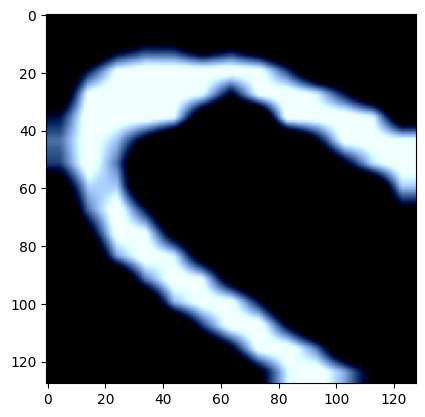

In [21]:
for batch in dataloader_train_simclr:
    print("\ngeneral batch info")
    print(type(batch))
    print(len(batch))
    print(type(batch[0]))
    print(len(batch[0]))

    print("\nimage batch info")
    print(type(batch[0][0]))
    print(batch[0][0].shape)
    print(batch[0][1].shape)
    plt.imshow(batch[0][0][21].permute(1, 2, 0))

    print("\ntarget")
    print(type(batch[1][21]))
    print(batch[1][21])

    print("\nfilename")
    print(type(batch[2][21]))
    print(batch[2][21])
    break

## Create the SimCLR Model
Now we create the SimCLR model. We implement it as a PyTorch Lightning Module
and use a ResNet-18 backbone from Torchvision. Lightly provides implementations
of the SimCLR projection head and loss function in the `SimCLRProjectionHead`
and `NTXentLoss` classes. We can simply import them and combine the building
blocks in the module.



In [22]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the module using the PyTorch Lightning Trainer on a single GPU.



In [23]:
model = SimCLRModel()

In [26]:
trainer = pl.Trainer(
    max_epochs=max_epochs,
    devices=1,
    accelerator=accelerator,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(model, dataloader_train_simclr)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
d:\__repos\ml_concepts\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_work

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Next we create a helper function to generate embeddings
from our test images using the model we just trained.
Note that only the backbone is needed to generate embeddings,
the projection head is only required for the training.
Make sure to put the model into eval mode for this part!



In [28]:
# For eval only

# PC-trained model
# model = SimCLRModel.load_from_checkpoint(
#     "./lightning_logs/version_8/checkpoints/epoch=9-step=2340.ckpt"
# )

# laptop-trained model
# maybe not-OK, as it was trained on 70k images (both train and test)
# model = SimCLRModel.load_from_checkpoint(
#     "./lightning_logs/version_0/checkpoints/epoch=9-step=10930.ckpt"
# )

In [29]:
model.eval()

SimCLRModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=